In [1]:
%matplotlib inline

In [2]:
import imageio as io
import matplotlib.pyplot as plt
from glob import glob
import json
import os, sys
import numpy as np
import pandas as pd
from PIL import Image
import glob
from skimage.transform import resize
from skimage.color import rgb2gray
import matplotlib.patches as patches
import cv2
import torch.optim as optim
from tensorboard_logger import log_value,configure

from yolo_net import Yolo
from yolo_loss import YoloLoss
from utils import *
import torch.utils.data as data_utils
import math


from torch.utils.data.dataloader import default_collate

import warnings
from functools import partial
warnings.filterwarnings('ignore')



In [3]:
data_directory = os.getcwd() + '\\Train_Dataset\\'
test_directory = os.getcwd() + '\\Test_Dataset\\'
labelpath = data_directory + 'gt.txt'
checkpointdir = os.getcwd() + '\\final_checkpoint\\'


In [4]:
batch_size = 4
IMG_W = 32
IMG_H = 32

X = prepare_data(data_directory,labelpath)

length = len(X)

train_split = 0.85
valid_split = 0.10
test_split = 0.05


indices1 = round(train_split * length)
indices2 = indices1 + round(valid_split*length)

train_data = X[:indices1]

valid_data = X[indices1:indices2]

test_data = X[indices2:]




In [5]:
a_train = data_iterator(train_data,batch_size=batch_size,size=(IMG_W,IMG_H))

a_valid = data_iterator(valid_data,batch_size=batch_size,size=(IMG_W,IMG_H))

In [6]:
net = Yolo(num_classes=2)
net = net.double()

In [7]:
batch_size

4

[13 22 13 23  1]


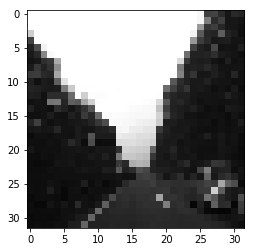

In [8]:
X_train = a_train.__next__()
draw_rectangle(X_train[0][0],X_train[1][0])

In [9]:
X_train[1]

array([[13, 22, 13, 23,  1],
       [23, 15, 24, 16,  1],
       [28, 17, 29, 19,  0],
       [ 9, 19, 10, 21,  1]])

In [10]:
optimizer = optim.Adam(net.parameters(), weight_decay=8e-6, lr=0.0001)

i = 0
best_valid_loss = 1000000

In [11]:
pL = YoloLoss(num_classes=2,anchors=net.anchors)
pL = pL.double()

In [12]:
configure("GTSDB/run-final")



In [ ]:
valid_iters = 100
for _ in range(2500):
    i += 1
    log = i%3 == 0
    is_valid = i%100 == 0 or i == 20
    pL.logging = log
    
        
    ims, labs = a_train.__next__()
    ims = ims.reshape((batch_size, IMG_W, IMG_H,3))

    ims = torch.from_numpy(np.transpose(ims, [0, 3, 1, 2]))   
    ims = Variable(ims)
    

    optimizer.zero_grad()
    output = net(ims)
    
    output = output.type(torch.DoubleTensor)
    
    loss, loss_coord, loss_conf,loss_cls = pL(output, labs)
    log_value('loss',loss,i)
    print("Iteration: {}, Loss:{:.2f} (Coord:{:.2f} Conf:{:.2f} Cls:{:.2f})".format(i + 1,loss,loss_coord,loss_conf,loss_cls))    
    loss.backward()
    optimizer.step()
    
    ### check if there are nan values in network
    if i % 100 == 0:
        if np.isnan(torch.sum(output).data[0]):
            print('NAN values')
            break
            
    if i % 50 == 0 or i ==1:
        torch.save(net.state_dict(), os.path.join(checkpointdir ,'_weights_%d.ckpt'%i))
        print(os.path.join(checkpointdir, '_weights_%d.ckpt'%i))
            
    '''
    if is_valid:
        losses = []
        for iter, batch in enumerate(a_valid):
            
            ims, labs = batch
            ims = ims.reshape((batch_size, IMG_W, IMG_H,3))

            ims = torch.from_numpy(np.transpose(ims, [0, 3, 1, 2]))   
            ims = Variable(ims)
    
            output = net(ims)
    
            output = output.type(torch.DoubleTensor)
    
            loss, loss_coord, loss_conf,loss_cls = pL(output, labs)
    
            losses.append(loss)
        
        valid_loss = np.mean(losses)
        log_value('valid_loss/total_loss', np.log(valid_loss + 1e-10), i)
        
        if valid_loss < best_valid_loss:
            torch.save(net.state_dict(), os.path.join(checkpointdir, '_weights_%d.ckpt'%i))
            print(os.path.join(checkpointdir, '_weights_%d.ckpt'%i))
            best_valid_loss = valid_loss
            
    '''
            
    

Iteration: 2, Loss:3.78 (Coord:0.60 Conf:1.75 Cls:1.44)
C:\Users\kriap\Desktop\TrafficSign\final_checkpoint\_weights_1.ckpt
Iteration: 3, Loss:3.45 (Coord:0.36 Conf:1.70 Cls:1.39)
Iteration: 4, Loss:4.21 (Coord:0.81 Conf:1.89 Cls:1.51)
Iteration: 5, Loss:3.30 (Coord:0.48 Conf:1.64 Cls:1.17)
Iteration: 6, Loss:3.51 (Coord:0.61 Conf:1.56 Cls:1.34)
Iteration: 7, Loss:3.95 (Coord:0.69 Conf:1.57 Cls:1.69)
Iteration: 8, Loss:3.14 (Coord:0.40 Conf:1.49 Cls:1.25)
Iteration: 9, Loss:3.15 (Coord:0.47 Conf:1.40 Cls:1.28)
Iteration: 10, Loss:3.17 (Coord:0.41 Conf:1.29 Cls:1.48)
Iteration: 11, Loss:3.39 (Coord:0.54 Conf:1.37 Cls:1.47)
Iteration: 12, Loss:3.01 (Coord:0.35 Conf:1.25 Cls:1.41)
Iteration: 13, Loss:3.22 (Coord:0.51 Conf:1.31 Cls:1.40)
Iteration: 14, Loss:3.11 (Coord:0.58 Conf:1.36 Cls:1.17)
Iteration: 15, Loss:2.65 (Coord:0.34 Conf:1.15 Cls:1.16)
Iteration: 16, Loss:2.96 (Coord:0.35 Conf:1.31 Cls:1.30)
Iteration: 17, Loss:2.80 (Coord:0.38 Conf:1.06 Cls:1.35)
Iteration: 18, Loss:2.45 (Co

Iteration: 142, Loss:0.61 (Coord:0.12 Conf:0.08 Cls:0.41)
Iteration: 143, Loss:0.83 (Coord:0.19 Conf:0.19 Cls:0.46)
Iteration: 144, Loss:0.79 (Coord:0.17 Conf:0.17 Cls:0.44)
Iteration: 145, Loss:0.85 (Coord:0.18 Conf:0.12 Cls:0.55)
Iteration: 146, Loss:2.82 (Coord:0.17 Conf:0.20 Cls:2.46)
Iteration: 147, Loss:0.65 (Coord:0.07 Conf:0.16 Cls:0.42)
